In [2]:
# Intended to be run via a virtual environment with the packages
# in ../../requirements.txt installed.

import numpy as np
import pandas as pd
import qspems
import matplotlib.pyplot as plt
import networkx as nx
import random

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

import graphinference.libs.qspems_sim_core as qspems_sim_core

import statsmodels
from statsmodels.tsa.api import VAR


random.seed(111)
np.random.seed(111)
rng = np.random.RandomState(111)

### Investigating Pairwise Edge Measures: 

**Lagged correlation corrected for confounding factors** method taken from

Schwartze et. al. *Network inference via process motifs for lagged correlation in linear stochastic processes*
(2022)

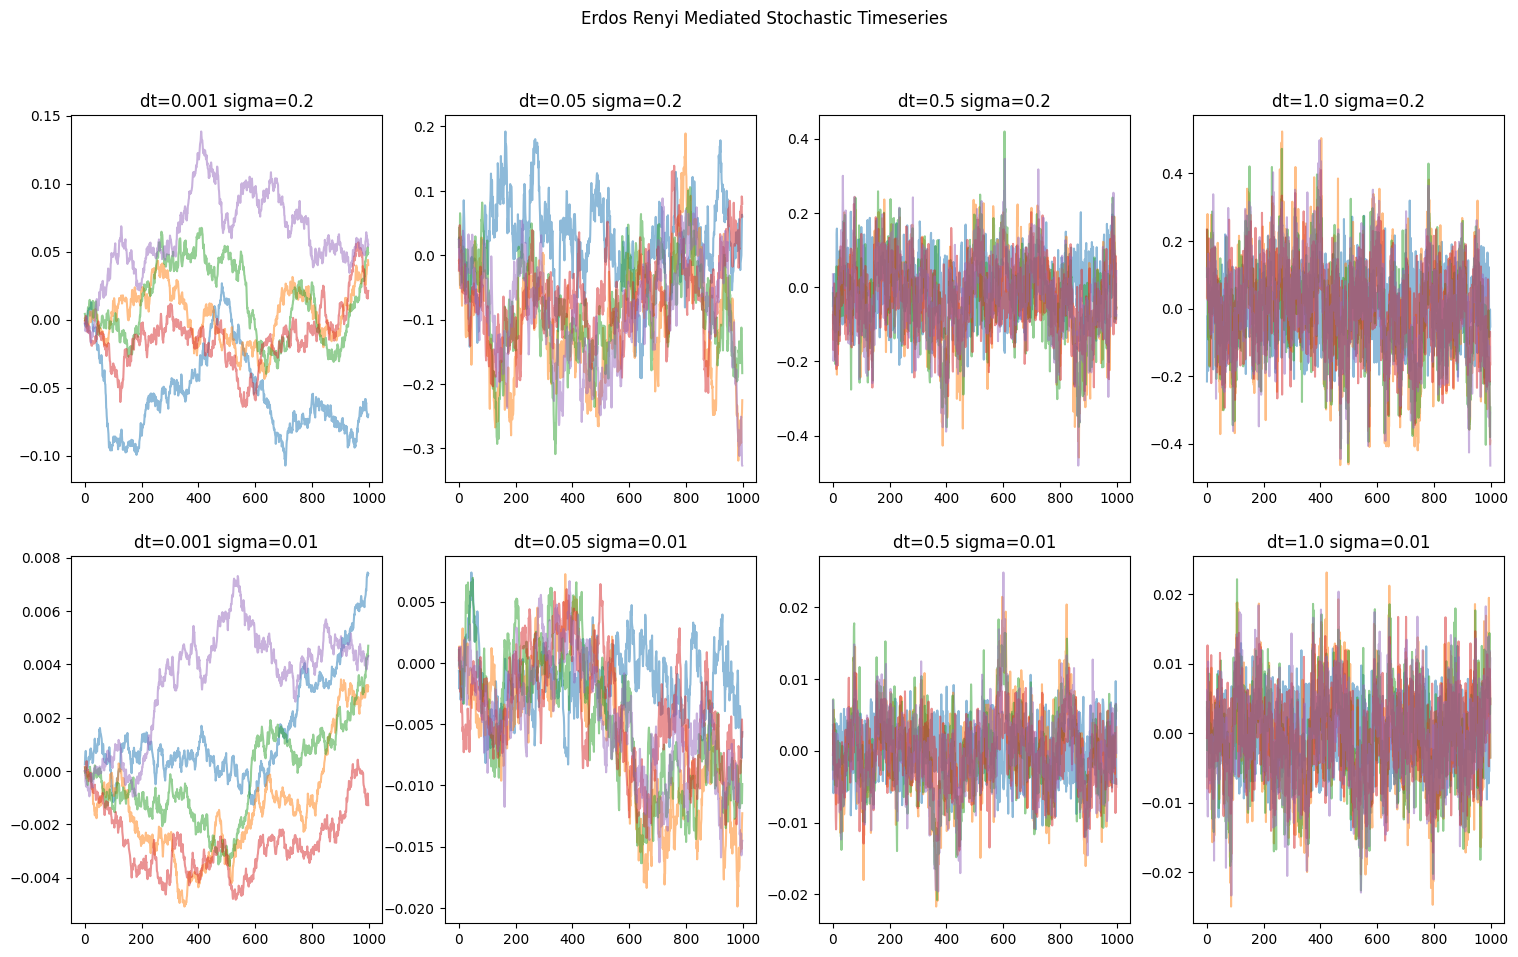

In [3]:
# Initialize an erdos-renyi adj matrix with desired mean degree
num_nodes = 5
mean_degree = 2
edge_prob = mean_degree / num_nodes
er = nx.erdos_renyi_graph(num_nodes, edge_prob, seed=rng)
adj = nx.adjacency_matrix(er).toarray()

# Plot

fig, ax = plt.subplots(2, 4)
dt_vals = [0.001, 0.05, 0.5, 1.0]
sigma_vals = [0.2, 0.01]

for j, dt in enumerate(dt_vals):
    for i, sig in enumerate(sigma_vals):
        # Simulate the time series as a stochastic process
        stochastic_timeseries = qspems_sim_core.sim(adj, dt=dt, sigma=sig)
        

        ax[i, j].plot(stochastic_timeseries.T, alpha=.5)
        ax[i, j].set_title(f"dt={dt} sigma={sig}")

fig.suptitle("Erdos Renyi Mediated Stochastic Timeseries")
fig.set_size_inches(18.5, 10.5)
plt.show()

In [4]:
num_edges = np.sum(adj == 1)

pred_adj = qspems.inf_via_LCRC(stochastic_timeseries, num_edges)

def compare_adj(adj: np.ndarray, pred_adj: np.ndarray):
    """Compares two zero-one adjacency matrixes and prints
    the number of true positives, true negatives, false positives
    and false negatives.

    Parameters
    ----------
    adj: A square numpy array that describes the true network.
    pred_adj: A numpy array with the same dimensions as `adj` that
        contains the predicted network.
    """
    true_pos = np.sum((adj == 1) & (pred_adj == 1))
    true_neg = np.sum((adj == 0) & (pred_adj == 0))
    false_pos = np.sum((adj == 0) & (pred_adj == 1))
    false_neg = np.sum((adj == 1) & (pred_adj == 0))

    print(
        f"Predicted Adj Shape {pred_adj.shape} \n"
        f"True Adj Shape {adj.shape} \n"
        f"Number of edges: {num_edges} \n"
        f"True Pos: {true_pos} \t False Pos: {false_pos} \n"
        f"False Neg: {false_neg} \t True Neg: {true_neg}"
    )

compare_adj(adj, pred_adj)

Predicted Adj Shape (5, 5) 
True Adj Shape (5, 5) 
Number of edges: 8 
True Pos: 8 	 False Pos: 0 
False Neg: 0 	 True Neg: 17


### Exploring Multivariate Transfer Entropy

In [5]:
reshaped_timeseries = np.reshape(stochastic_timeseries, (5, 1000, 1))
data = Data(reshaped_timeseries)


# Initialize multivariate transfer entropy
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtGaussianCMI',
            'max_lag_sources': 5,
            'min_lag_sources': 1}

# Infer network
results = network_analysis.analyse_network(settings=settings, data=data)


    Error importing Cython fast embedding module. Continuing with slow Python implementation.

    This may take a long time.

    


Adding data with properties: 5 processes, 1000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 5) 
maximum statistic, n_perm: 200
 -- not significant

No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
no sources selected, nothing to prune ...

---------------------------- (4) final statistics
no sources selected ...
final source samples: []
final targ

In [6]:
mte_pred_adj = results.get_adjacency_matrix('binary').weight_matrix
compare_adj(adj, mte_pred_adj)

Predicted Adj Shape (5, 5) 
True Adj Shape (5, 5) 
Number of edges: 8 
True Pos: 8 	 False Pos: 0 
False Neg: 0 	 True Neg: 17


### Exploring Vector Autoregressive Models

In [7]:
var_model = VAR(stochastic_timeseries.T)
# The model accounts for five timesteps of lag,
# and has a constant has no trend.
result = var_model.fit(maxlags=1, verbose=True)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Jan, 2023
Time:                     15:07:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -53.9656
Nobs:                     999.000    HQIC:                  -54.0570
Log likelihood:           19971.8    FPE:                3.15527e-24
AIC:                     -54.1130    Det(Omega_mle):     3.06221e-24
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000028         0.000143            0.193           0.847
L1.y1         0.001548         0.031804            0.049           0.961
L1.y2        -0.008544         0.021934           -0.390           0.697
L1.y3         0.004050

In [8]:
# I think the coefficient matrix is organized such that
# coefs[i, j, k] is the coefficient of the effect of
# y_{k+1}[n-(i + 1)] on y_{j+1}[n]

# We verify this by hand using the printout above
# This should describe the coefficient of the effect
# of y5[n-3] on y4[n] 
i = 1
j = 2
k = 3
print(f"Entry in coeff[{i-1}, {j-1}, {k-1}]: {result.coefs[i-1, j-1, k-1]}"
f"\nCompare to printout: Results for equation y{j}, entry L{i}.y{k}")

Entry in coeff[0, 1, 2]: 0.46853086569596764
Compare to printout: Results for equation y2, entry L1.y3


In [9]:
# I think the p value matrix is organized such that
# the p-value of the effect of y_k[n-i] on y_j[n]
# is stored in pvals[(i - 1)*len(y) + k, j-1]

i = 1
j = 2
k = 3
len_y = 5
pval = result.pvalues[(i - 1) * len_y + k, j-1]
print(f"Entry in `pvalues[(i - 1) * len_y + k, j-1]`: {pval}"
f"\nCompare to printout: Results for equation y{j}, entry L{i}.y{k}")

Entry in `pvalues[(i - 1) * len_y + k, j-1]`: 9.805234288845236e-84
Compare to printout: Results for equation y2, entry L1.y3


In [10]:
def var_model_coeff_one_based(
    result: statsmodels.tsa.vector_ar.var_model.VARResultsWrapper,
    source_idx: int,
    target_idx: int,
    lag_in_source: int,
) -> float:
    """Returns the coefficient of the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.

    To correspond to the printout generated by `result.summary()`
    `source_idx`, `target_idx` and `lag_in_souce` are assumed to
    be one based.

    Parameters
    -----------
    result: The return value of statsmodels.ts.api.VAR.fit(...)
    source_idx: Which entry of y (the modeled time series vector)
        is the source of the effect. Assumed to be a one based index.
    target_idx: Which entry of y (the modeled time series vector)
        is impacted by the effect. Assumed to be a one based index.
    lag_in_source: The time lag that modifies the source index. Must
        be greater than zero.

    Returns
    -------
    The coefficient of the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.
    """
    return result.coefs[lag_in_source - 1, target_idx - 1, source_idx - 1]

def var_model_pval_one_based(
    result: statsmodels.tsa.vector_ar.var_model.VARResultsWrapper,
    source_idx: int,
    target_idx: int,
    lag_in_source: int,
) -> float:
    """Returns the p-value for the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.

    To correspond to the printout generated by `result.summary()`
    `source_idx`, `target_idx` and `lag_in_souce` are assumed to
    be one based.

    Parameters
    -----------
    result: The return value of statsmodels.ts.api.VAR.fit(...)
    source_idx: Which entry of y (the modeled time series vector)
        is the source of the effect. Assumed to be a one based index.
    target_idx: Which entry of y (the modeled time series vector)
        is impacted by the effect. Assumed to be a one based index.
    lag_in_source: The time lag that modifies the source index. Assumed
        to be one based. Must be greater than zero.

    Returns
    -------
    The p-value for the effect of
    `y_{source_idx}[n - lag_in_source]` on `y_{target_idx}[n]`
    where `n` is any arbitrary timestep.
    """
    return result.pvalues[(lag_in_source - 1) * result.neqs + source_idx, target_idx-1]


#### Make an adj matrix using p-values and coeffs

In [11]:
var_adj = np.zeros((num_nodes,num_nodes))
var_adj_p_val = np.zeros((num_nodes,num_nodes))

for i in range(num_nodes):
    for j in range(num_nodes):
        var_adj[i, j] = var_model_coeff_one_based(result, i+1, j+1, 1)
        var_adj_p_val[i, j] = var_model_pval_one_based(result, i+1, j+1, 1)
    
print(var_adj)
significant_edges = (var_adj_p_val < 0.05).astype(float)

compare_adj(adj, significant_edges)

[[ 0.00154841 -0.01467263  0.0580617  -0.03847798 -0.02379703]
 [-0.00854395 -0.02129444  0.41264679  0.44397959  0.43336001]
 [ 0.00404991  0.46853087 -0.01060404  0.00913138  0.4121879 ]
 [-0.01114248  0.40983368  0.00060937  0.0276192  -0.01054475]
 [-0.01012918  0.38939257  0.42977254  0.00334711 -0.00802458]]
Predicted Adj Shape (5, 5) 
True Adj Shape (5, 5) 
Number of edges: 8 
True Pos: 8 	 False Pos: 0 
False Neg: 0 	 True Neg: 17


### Tests

In [169]:
import unittest

class TestNetworkInferenceMethods(unittest.TestCase):
    
    def test_var_one_based(self):        
        A = np.array(
            [[0., 1.],
            [1., 0.]]
        )
        time_series = qspems_sim_core.sim(A, dt=1., sigma=.2)
        var_model = VAR(time_series.T)
        result = var_model.fit(maxlags=1)
        self.assertGreater(var_model_coeff_one_based(result, 1, 2, 1), .1)
        self.assertGreater(0.05, var_model_pval_one_based(result, 2, 1, 1))


tests = TestNetworkInferenceMethods()
tests.test_var_one_based()        
            